In [1]:
import pandas as pd

In [2]:
url = 'https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv'
df = pd.read_csv(url)
df

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


In [3]:
df['variety'] = df['variety'].replace('Setosa', 0.0)
df['variety'] = df['variety'].replace('Versicolor', 1.0)
df['variety'] = df['variety'].replace('Virginica', 2.0)
df

C:\Users\yannan\AppData\Local\Temp\ipykernel_31576\1272247068.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['variety'] = df['variety'].replace('Virginica', 2.0)


,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


In [4]:
X = df.drop('variety', axis=1).values
y = df['variety'].values

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 1) 划分数据
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2) 定义模型
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [6]:
# 3) 参数网格（可按需精简/扩展）
param_grid = {
    "n_estimators": [100, 200, 400],
    # "max_depth": [None, 10, 20, 30],
    # "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True],
    # 类不平衡可加这行：'class_weight': [None, 'balanced']
}

In [7]:
# 4) 交叉验证方案与评分
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="f1_macro",       
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# 5) 训练 + 搜索
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

# 6) 在测试集上评估
best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best params: {'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 100}
Best CV score: 0.9663367569249923
[[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]
              precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000        10
         1.0     1.0000    0.9000    0.9474        10
         2.0     0.9091    1.0000    0.9524        10

    accuracy                         0.9667        30
   macro avg     0.9697    0.9667    0.9666        30
weighted avg     0.9697    0.9667    0.9666        30



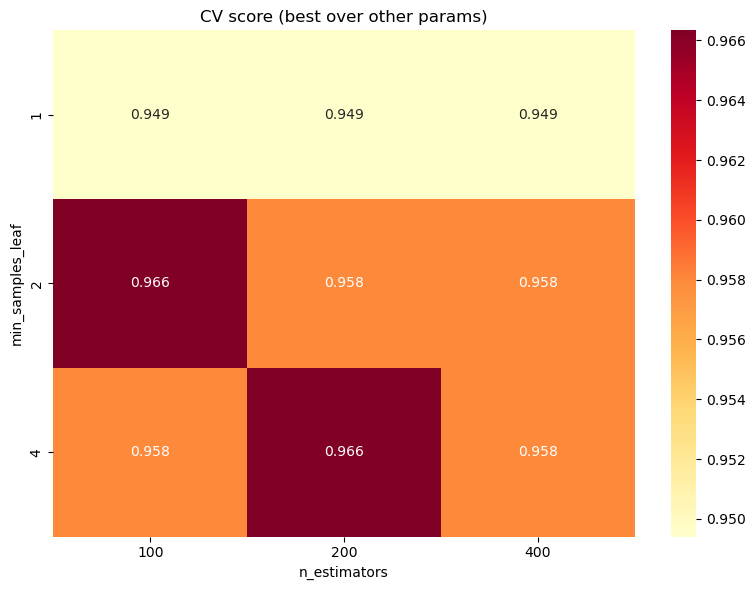

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

res = pd.DataFrame(grid.cv_results_)

# 选择要做热力图的两维（任选）
row_key = "param_min_samples_leaf"
col_key = "param_n_estimators"

# 其他参数列
param_cols = [c for c in res.columns if c.startswith("param_")]
other_cols = [c for c in param_cols if c not in [row_key, col_key]]

# 对相同(row,col)组合，取其它参数上的最佳分数（你也可以改成 .mean())
agg = (res
       .groupby([row_key, col_key], dropna=False)["mean_test_score"]
       .max()                      # ← 也可以换成 .mean()
       .unstack(col_key))

plt.figure(figsize=(8,6))
sns.heatmap(agg, annot=True, fmt=".3f", cmap="YlOrRd")
plt.title("CV score (best over other params)")
plt.ylabel(row_key.replace("param_","")); plt.xlabel(col_key.replace("param_",""))
plt.tight_layout(); plt.show()

Best params: {'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 100}
Accuracy: 0.9667
Macro-F1: 0.9666

Top 10 feature importances:
petal.width     0.4437
petal.length    0.4374
sepal.length    0.1106
sepal.width     0.0082
dtype: float64


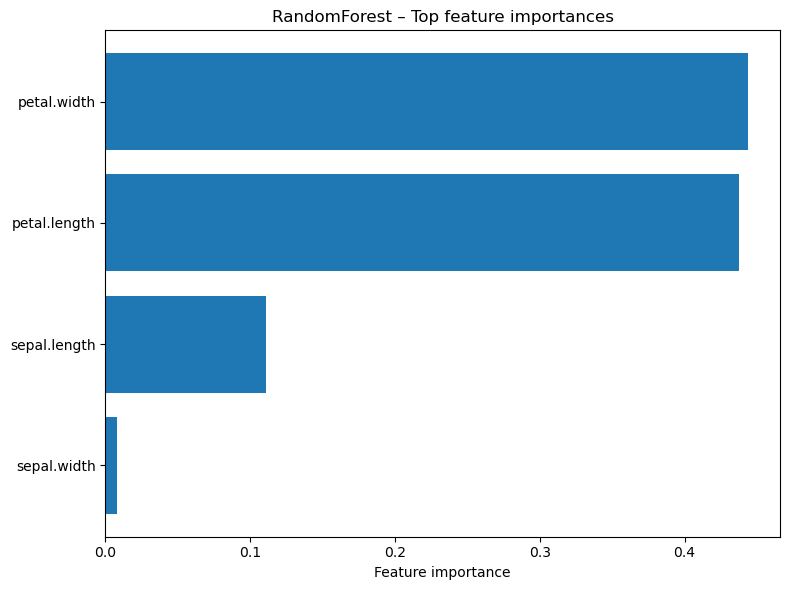

In [29]:
from sklearn.metrics import accuracy_score, f1_score

# 1) 取最佳模型
best_rf = grid.best_estimator_
print("Best params:", grid.best_params_)

# 2) 测试集评估
y_pred = best_rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"Accuracy: {acc:.4f}")
print(f"Macro-F1: {macro_f1:.4f}")



# 3) 特征重要性
feat_names = df.drop('variety', axis=1).columns
# feat_names = [f"feat_{i}" for i in range(best_rf.n_features_in_)]
importances = pd.Series(best_rf.feature_importances_, index=feat_names)\
                .sort_values(ascending=False)

print("\nTop 10 feature importances:")
print(importances.head(10).round(4))

# 可视化（前10个）
topk = importances.head(10).round(4)
plt.figure(figsize=(8,6))
plt.barh(topk.index, topk.values)
plt.gca().invert_yaxis()
plt.xlabel("Feature importance")
plt.title("RandomForest – Top feature importances")
plt.tight_layout()
plt.show()

